## Introduction

- The goal of this project is to implement a rectification algorithm on an image distorted by affine transform due to viewpoint, which is often seen in document scanning an digital photography of painting. 

- The resulting rectified image will have the boundary of the object along the horizontal or the vertical direction of an image.

In [591]:
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2

In [592]:
# define common functions to load and plot images
def load_Imagefromfile(path):
    image = cv2.imread(path, cv2.IMREAD_COLOR) 
    return image

def cv2plt(img):
    plt.figure(figsize=(10,10))        # To change the size of figure
    plt.axis('on')
    if np.size(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    else:
        plt.imshow(img,cmap='gray',vmin=0,vmax=255)  
    plt.show()

In [771]:
test1 = load_Imagefromfile("./data/test1.jpg")

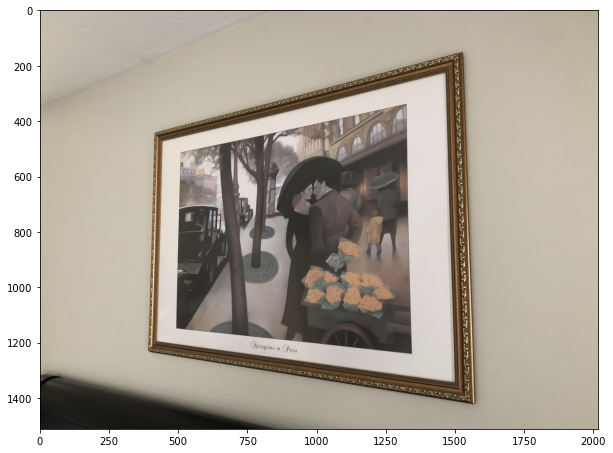

In [772]:
cv2plt(test1)

we aim to first capture the edges of the image, hence we convert the image to grayscale

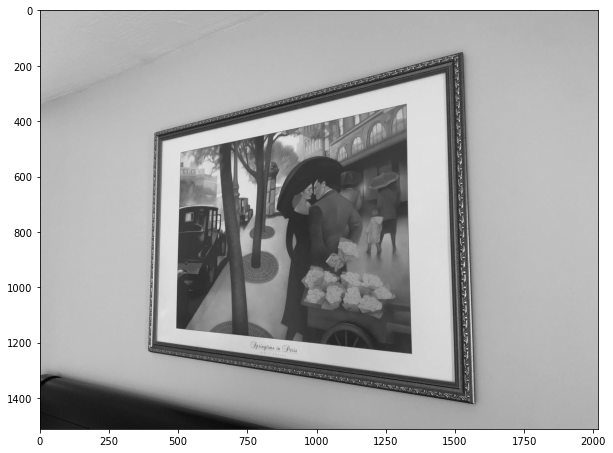

In [773]:
#convert image to gray scale
gray = cv2.cvtColor(test1, cv2.COLOR_BGR2GRAY)
cv2plt(gray)

Edge detection is very sensitive to noises, hence we first apply a guassian filter to smoothen the image

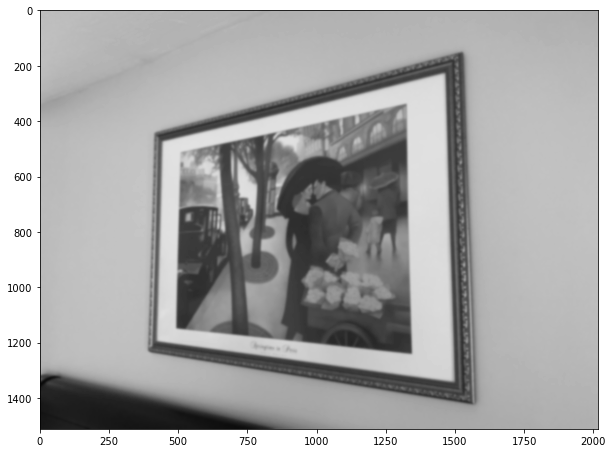

In [774]:
#apply guassian filter
filtered_image = cv2.GaussianBlur(gray, (21,21), 0)
cv2plt(filtered_image)

In [775]:
#use canny edge detection
edges = cv2.Canny(filtered_image, 100, 90)

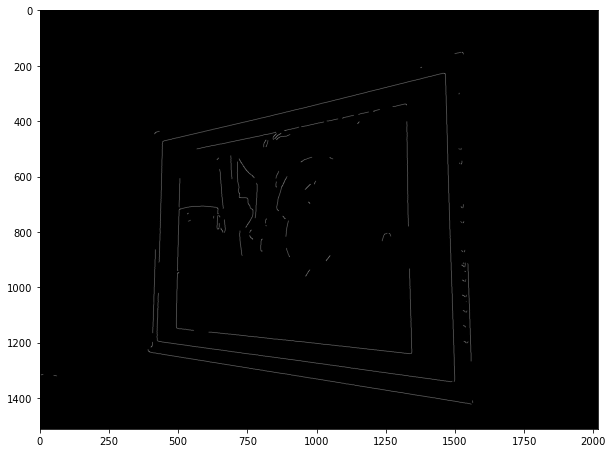

In [776]:
cv2plt(edges)

The below is an implementation of hough transformation. 

- In the Hough Transform, each point in the original image space (x, y) is transformed into a parameter space (Hough space) representing the parameters of the shape to be detected. 

- For detecting lines, this parameter space is typically represented by slope-intercept form (ρ, θ), where ρ is the perpendicular distance from the origin to the line and θ is the angle between the x-axis and the normal line from the origin to the closest point on the line. 

- Each edge point in the image casts a vote in the parameter space for the possible lines that could have produced it. The accumulator variable which is a 2d array effectively accumulates this vote.

In [777]:
def hough_line(img):
    if len(img.shape) == 3:
        if img.shape[2] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ret,img = cv2.threshold(img,50,255,cv2.THRESH_BINARY)
    thetas = np.deg2rad(np.arange(-90.0, 90.0))
    height, width = img.shape
    # max_dist
    diag_len = np.int64(np.ceil(np.sqrt(width * width + height * height)))
    #print(diag_len)
    rhos = np.linspace(-diag_len, diag_len, int(diag_len * 2.0))
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)
    accumulator = np.int64(np.zeros((int(2 * diag_len), num_thetas)))
    y_idxs, x_idxs = np.nonzero(img) # (row, col) indexes to edges
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        for t_idx in range(num_thetas):
            # Calculate rho. diag_len is added for a positive index
            rho = round(x * cos_t[t_idx] + y * sin_t[t_idx]) + diag_len
            accumulator[rho, t_idx] += 1
    return accumulator, thetas, rhos

In [778]:
# get accumulator, thetas and rhos values
accum, thetas, rhos = hough_line(edges)

In [779]:
# create a blank canvas for visualizing captured lines from hough transform
height, width = test1.shape[0], test1.shape[1]
blank = np.zeros((height, width))

# we set the threshold to half the max accumulated vote
lines = cv2.HoughLines(edges, 1, np.pi / 180, int(accum.max()/3))

if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 10000*(-b)), int(y0 + 10000*(a)))
        pt2 = (int(x0 - 10000*(-b)), int(y0 - 10000*(a)))
        cv2.line(blank, pt1, pt2, 255, 3, cv2.LINE_AA)


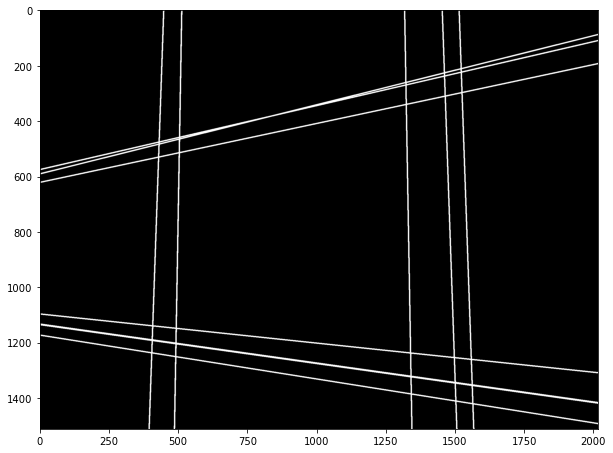

In [780]:
blank = blank.astype(np.uint8)
cv2plt(blank)

Notice that there are multiple lines detected, we have to identify the quadrilateral of the object from these lines

We can use Harris Corner detection method to do this. The Harris Corner detection method consist of the following steps:

- Gradient Calculation: The algorithm begins by computing the gradients of the image using derivative filters, typically the Sobel operator. These gradients highlight regions of rapid intensity change in the image, which often occur at corners.

- Structure Tensor: The Harris Corner Detection algorithm computes a structure tensor for each pixel in the image. This tensor summarizes the local spatial distribution of gradients around the pixel. It is essentially a covariance matrix of the gradients.

- Corner Response Function: Using the elements of the structure tensor, the algorithm computes a corner response function for each pixel. This function measures how likely a pixel is to be located at a corner based on the gradients in its neighborhood. The response function is typically defined as the determinant of the structure tensor minus a fraction of the trace squared.

- Non-Maximum Suppression: After computing the corner response function for each pixel, the algorithm applies non-maximum suppression to suppress responses that are not local maxima. This ensures that only the most significant corners are detected.

- Thresholding and Localization: Finally, a threshold is applied to the corner response values to select only the strongest corners. Additionally, a process called corner localization is performed to refine the corner coordinates, typically by fitting a model to the local region around each corner.

We will just make use of the prebuilt function in OpenCV library

In [781]:
corners = cv2.cornerHarris(blank, blockSize=11, ksize=21, k=0.1)
threshold =  0.01*corners.max()
corner_coordinates = np.argwhere(corners > threshold)

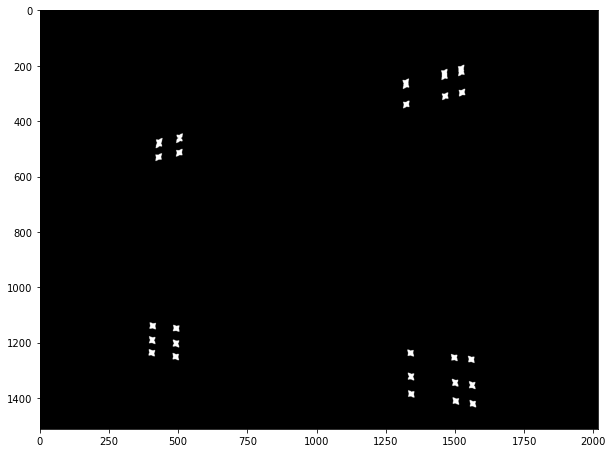

In [782]:
#Visualize the corners
corners1 = np.zeros((height, width))
for coord in corner_coordinates:
    x, y = coord[1], coord[0]
    cv2.circle(corners1, (x, y), 1, 255, 0)
cv2plt(corners1)

The goal is to obtain 4 corners. However there are multiple corners detected due to the extra lines present. Hence we implement a method to obtain the final 4 corners. This is done by the following steps:

1) compute the approximate centroid with respect to all corner candidates

2) calculate the distance of all corner candidates to the centroid, and sort them from highest to lowest distance

3) add the first point (highest distance) to our finalized corner list.

4) for subsequent points, we choose the points from the sorted list in order (points with higher distance from centroid get picked first) and add them to the finalized list as long as they have a certain minimum distance to existing finalized corner points 

5) we stop this once we obtained 4 finalized points

In [783]:
def euclidean_distance(point1, point2):
    # Calculate squared Euclidean distance
    return np.linalg.norm(point1- point2)

def sort_points_by_distance(arr, ref_point):
    # Create a list of pairs: (distance, point)
    distances_and_points = [(euclidean_distance(point, ref_point), point) for point in arr]

    # Sort by distance
    distances_and_points.sort(key=lambda x: x[0], reverse = True)
    
    # Extract the sorted points
    sorted_points = [point for _, point in distances_and_points]
    sorted_distances = [distance for distance, _ in distances_and_points]
    return sorted_points,sorted_distances

In [784]:
#compute approx centroid
centroid = np.mean(corner_coordinates, axis=0)

#sort all candidates corner based on distance form centroid
sorted_corners,sorted_distances = sort_points_by_distance(corner_coordinates, centroid)

# algorithm to pick 4 final corner points
final_corners = []
i = 0
while len(final_corners) < 4:
    corner = sorted_corners[i]
    if len(final_corners) == 0:
        final_corners.append(corner)
    else:
        distancelist = []
        for e_corner in final_corners:
            distance = euclidean_distance(corner, e_corner)
            distancelist.append(distance)
        #we set criteria that real corner points must be 50% of maximum distance of any point to centroid
        if min(distancelist) > 0.5*sorted_distances[0]:
            final_corners.append(corner)
        i += 1

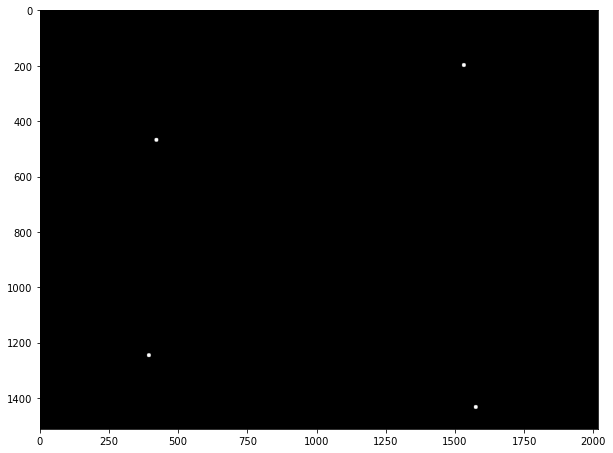

In [785]:
#Visualize the finalized corners
corners2 = np.zeros((height, width))
for coord in final_corners:
    x, y = coord[1], coord[0]
    cv2.circle(corners2, (x, y), 2, 255, 10)
cv2plt(corners2)

In [786]:
final_corners

[array([ 198, 1531], dtype=int64),
 array([1245,  393], dtype=int64),
 array([1432, 1574], dtype=int64),
 array([468, 420], dtype=int64)]

notice that the finalized corner points are not arranged in order, in order to simplify the subsequent steps, we sort them such that they are arranged in a clockwise order. This is done by the following steps:

1) Sort all the corners based on their y values.

2) split into the top 2 corner points and bottom 2 corner points

3) sort the top 2 corner points based on their x values, the same is done for the bottom 2 corner points (however sorted in reverse order)

4) Concatenate the two list together

In [787]:
# algoirthm to sort the corner points into clockwise order
def sortcoord(corners):
    corners.sort(key=lambda x: x[0], reverse = False)
    toptwo = corners[:2]
    bottomtwo = corners[2:]
    toptwo.sort(key=lambda x: x[1], reverse = False)
    bottomtwo.sort(key=lambda x: x[1], reverse = True)
    sorted_corners = toptwo + bottomtwo
    return sorted_corners

In [788]:
final_corners = sortcoord(final_corners)

In [789]:
# compile final corner points from the format (y, x) to (x, y)
src_points = np.array([[final_corners[0][1],final_corners[0][0]],
                       [final_corners[1][1],final_corners[1][0]],
                       [final_corners[2][1],final_corners[2][0]],
                       [final_corners[3][1],final_corners[3][0]]],
                      dtype = np.float32)

Next, in order to obtain the rough width and height of the rectified image, we compute the distance of the 3 points to the top left corner point

In [790]:
distances = [euclidean_distance(point, final_corners[0]) for point in final_corners]

In [791]:
# compute the destination points
x1_new = min(x[0] for x in src_points)
y1_new = min(y[1] for y in src_points)
x2_new = x1_new + distances[1]
y2_new = y1_new
x3_new = x2_new
y3_new = y1_new + distances[3]
x4_new = x1_new
y4_new = y3_new

In [792]:
# compile destination points to the format (x, y)
dst_points = np.array([[x1_new, y1_new], [x2_new, y2_new], [x3_new, y3_new], [x4_new, y4_new]], dtype=np.float32)

Perspective transform is given by the following, where M is the transformation matrix

$$ [x', y', w']^t = [M] [x, y, 1]^t $$

In [793]:
# compute M
M = cv2.getPerspectiveTransform(src_points, dst_points)

In [794]:
# compute the rectified image
warped_image = cv2.warpPerspective(test1, M, (test1.shape[1], test1.shape[0]))

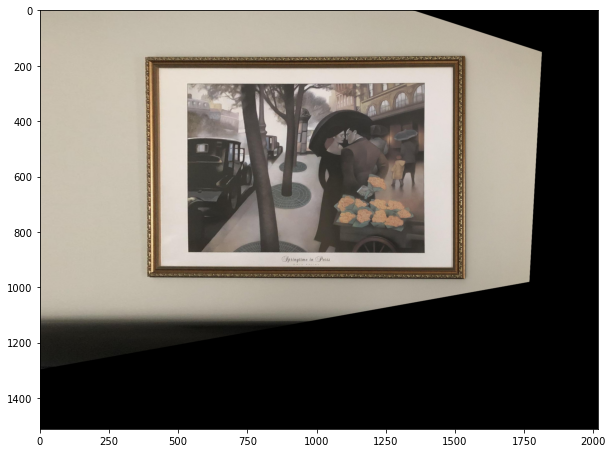

In [795]:
cv2plt(warped_image)

In [796]:
cv2.imwrite('./data/rectified.jpg',warped_image)

True

In [12]:
# import numpy as np
# def hough_line(img):
#     if len(img.shape) == 3:
#         if img.shape[2] == 3:
#             img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#             ret,img = cv2.threshold(img,50,255,cv2.THRESH_BINARY)
#     thetas = np.deg2rad(np.arange(-90.0, 90.0))
#     height, width = img.shape
#     # max_dist
#     diag_len = np.int64(np.ceil(np.sqrt(width * width + height * height)))
#     #print(diag_len)
#     rhos = np.linspace(-diag_len, diag_len, int(diag_len * 2.0))
#     cos_t = np.cos(thetas)
#     sin_t = np.sin(thetas)
#     num_thetas = len(thetas)
#     accumulator = np.int64(np.zeros((int(2 * diag_len), num_thetas)))
#     y_idxs, x_idxs = np.nonzero(img) # (row, col) indexes to edges
#     for i in range(len(x_idxs)):
#         x = x_idxs[i]
#         y = y_idxs[i]
#         for t_idx in range(num_thetas):
#             # Calculate rho. diag_len is added for a positive index
#             rho = round(x * cos_t[t_idx] + y * sin_t[t_idx]) + diag_len
#             accumulator[rho, t_idx] += 1
#     return accumulator, thetas, rhos

# def get_twosegments(resized_accumulator):
#     segmentlist = []
#     for i in range(4):
#         width = resized_accumulator.shape[1]
#         segment = resized_accumulator[:,int(width*(i)/4):int(width*(i+1)/4)]
#         #cv2plt(segment)
#         segmentlist.append(segment.max())

#     max_val = max(segmentlist)
#     selected_seg = segmentlist.index(max_val)
#     segment_1 = resized_accumulator[:,int(width*(selected_seg)/4):int(width*(selected_seg+1)/4)]
#     selected_seg2 = (selected_seg+2)%4
#     segment_2 = resized_accumulator[:,int(width*(selected_seg2)/4):int(width*(selected_seg2+1)/4)]
#     return segment_1, segment_2, selected_seg, selected_seg2

# def find_two_max_position_2d(first_point, candidate, arr_np):
    
#     arr_np[candidate] = 0
#     candidate = np.unravel_index(np.argmax(arr_np), arr_np.shape)
    
#     x1, y1 = first_point
#     x2, y2 = candidate
#     distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
#     height, width = arr_np.shape
    
#     if distance/(height+width) > 0.1:
#         return candidate
#     else:
#         return find_two_max_position_2d(first_point, candidate, arr_np)

# def get_twopoints(segment_1, selected_seg):    
#     arr_np = np.array(segment_1)
#     width = segment_1.shape[1]*4
#     first_point = np.unravel_index(np.argmax(arr_np), arr_np.shape)
#     candidate = first_point
#     second_point = find_two_max_position_2d(first_point, candidate, arr_np)
    
#     first_point = (first_point[0], first_point[1]+int(width*(selected_seg)/4))
#     second_point = (second_point[0], second_point[1]+int(width*(selected_seg)/4))
    
#     return first_point, second_point

# def getline(theta,rho,image_width, image_height):
#     x_start = 0
#     y_start = int(np.cos(theta)/np.sin(theta)*x_start - rho/np.sin(theta))
#     x_end = image_width
#     y_end = int(np.cos(theta)/np.sin(theta)*x_end - rho/np.sin(theta))
    
#     return (x_start,y_start),(x_end,y_end)

# def getline2(theta,rho,image_width, image_height):
#     y_start = 0
#     x_start = int(np.sin(theta)/np.cos(theta)*y_start + rho/np.cos(theta))
#     y_end = image_width
#     x_end = int(np.sin(theta)/np.cos(theta)*y_end + rho/np.cos(theta))
    
#     return (x_start,y_start),(x_end,y_end)


#==============================================================================================================

# accumulator, thetas, rhos = hough_line(lines1)
# resized_accumulator = cv2.resize(accumulator.astype(float), (100, 100), interpolation=cv2.INTER_AREA)

# segmentlist = []
# for i in range(4):
#     width = resized_accumulator.shape[0]
#     segment = resized_accumulator[:,int(width*(i)/4):int(width*(i+1)/4)]
#     #cv2plt(segment)
#     segmentlist.append(segment.max())

# max_val = max(segmentlist)
# selected_seg = segmentlist.index(max_val)
# segment_1 = resized_accumulator[:,int(width*(selected_seg)/4):int(width*(selected_seg+1)/4)]
# selected_seg2 = (selected_seg+2)%4
# segment_2 = resized_accumulator[:,int(width*(selected_seg2)/4):int(width*(selected_seg2+1)/4)]

# first_point, second_point = get_twopoints(segment_1,selected_seg)
# points = [first_point, second_point]

# first_point, second_point = get_twopoints(segment_2,selected_seg2)
# points2 = [first_point, second_point]

# pointsmap = np.zeros_like(resized_accumulator)
# for point in points:
#     x = point[1]
#     y = point[0]
#     cv2.circle(resized_accumulator , (x,y), 1, 255, -1)
# for point in points2:
#     x = point[1]
#     y = point[0]
#     cv2.circle(resized_accumulator , (x,y), 1, 255, -1)
# #----------------------------------------------------------------------------------------
# segment_1, segment_2, selected_seg, selected_seg2 = get_twosegments(accumulator)
# # first_point, second_point = get_twopoints(segment_1,selected_seg)
# # first_point2, second_point2 = get_twopoints(segment_2,selected_seg2)
# # points = [
# #     first_point,
# #     second_point,
# #     first_point2,
# #     second_point2
# # ]
# points = []
# for i, row in enumerate(accumulator):
#     for j, column in enumerate(row):
#         if column >400:
#             points.append((i,j))

# height, width = test1.shape[0], test1.shape[1]
# blank = np.zeros((height, width))

# for point in points:
#     theta = thetas[point[1]]
#     rho = rhos[point[0]]
#     if np.sin(theta) == 0:
#         pt1, pt2 = getline2(theta,rho,width, height)
#     else:
#         pt1, pt2 = getline(theta,rho,width, height)
#     cv2.line(blank, pt1, pt2, 255, 3)
    
# cv2plt(blank)